In [10]:
#import required packages
import math
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.rcParams["image.cmap"] = "gray"
from skimage import draw
import time
from numpy import random
from scipy.spatial import KDTree

In [11]:
#initialize functions for drawing cells

#for rectangle with position(cx,cy), width w, length l, and orientation theta (wrt the vertical), find coordinates of 4 vertices
def rect_vertices(cx, cy, w, l, theta):
    d = math.sqrt(w**2 + l**2) #half length of rectangle diagonal
    phi1 = theta - math.atan(w/l) #angle between vertical and first vertex
    phi2 = theta + math.atan(w/l) #angle between vertical and second vertex
    a1 = d*math.sin(phi1)
    b1 = d*math.cos(phi1)
    a2 = d*math.sin(phi2)
    b2 = d*math.cos(phi2)
    r = [cy + b1, cy + b2, cy - b1, cy - b2]
    c = [cx + a1, cx + a2, cx - a1, cx - a2]
    return r, c

#find set of coordinates that makes up circular endcaps for a rectangle with vertex coordinates vert_r and vert_c and width w
def rect_end_circles(vert_r, vert_c, w):
    r1 = (vert_r[0]+vert_r[1])/2
    c1 = (vert_c[0]+vert_c[1])/2
    r2 = (vert_r[2]+vert_r[3])/2
    c2 = (vert_c[2]+vert_c[3])/2
    rr1, cc1 = draw.ellipse(r1, c1, w, w)
    rr2, cc2 = draw.ellipse(r2, c2, w, w)
    return np.append(rr1,rr2), np.append(cc1,cc2)


def add_round_rects_labels(Img, Lbl, data, N, N0, log=False):
    """
    draw N randomly aligned rectangular cells with circular endcaps
    
    Img (np.array): array on which cells should be drawn
    Lbl (np.array): array on which cell labels should be added
    data (np.array): contains existing cell coordinates, dimensions, and orientations
    N0 (int): number of previously drawn cells
    log (bool): True if you want cell lengths to be sampled from lognormal instead of normal distribution

    return: updates Img, Lbl, data, and N with new cells
    """
    Ncell = N0
    #initialize all cell coordinates (make sure cells are not drawn too close to the edge)
    #cell dimension parameters (l_mean, w_mean, l_std, w_std) must be set outside of the function
    x = random.rand(N)*(len(Img[0]) - 4*(l_mean+w_mean)) + 2*(l_mean+w_mean)
    y = random.rand(N)*(len(Img) - 4*(l_mean+w_mean)) + 2*(l_mean+w_mean)
    if log:
        l = np.random.lognormal(mean=log_mean, sigma=log_std, size=(N))/pix
    else:
        l = l_mean + random.randn(N)*l_std
    w = w_mean + random.randn(N)*w_std
    theta = (2*random.rand(N)-1)*math.pi

    for a, b, c, d, e in zip(x, y, l, w, theta):
        rows, cols = rect_vertices(cx=a, cy=b, l=c-d, w=d, theta=e)
        rr, cc = draw.polygon(rows,cols)
        rrE , ccE = rect_end_circles(rows,cols,d)
        #rr,cc is complete set of cell coordinates
        rr = np.append(rr,rrE)
        cc = np.append(cc, ccE)
        k = 0
        while np.sum(Img[rr,cc]) > 5: #set overlap threshold
            #if overlap with existing cells is too large,
            #rotate cell through small angles and check if it fits
            e = (math.pi + e + 0.1)%(2*math.pi) - math.pi
            rows, cols = rect_vertices(cx=a, cy=b, l=c-d, w=d, theta=e)
            rr, cc = draw.polygon(rows,cols)
            rrE , ccE = rect_end_circles(rows,cols,d)
            rr = np.append(rr,rrE)
            cc = np.append(cc, ccE)
            if k > 32:
                #stop trying to fit cell after rotation through pi radians
                break
            k += 1
        else:
            Img[rr,cc] = 1
            data[Ncell] = (a,b,c,d,e)
            Ncell += 1
            Lbl[rr,cc] = Ncell

    return data, Ncell

def add_round_rects_labels_aligned(Img, Lbl, data, N, N0, noise = 0.1, thresh = 5, clustered = False, clust_size = 300, log=False):
    """
    draw N rectangular cells with circular endcaps aligned with their neighbors
    
    Img (np.array): array on which cells should be drawn
    Lbl (np.array): array on which cell labels should be added
    data (np.array): contains existing cell coordinates, dimensions, and orientations
    N (int): number of cells to be drawn
    N0 (int): number of previously drawn cells
    noise (float): amount of random variation in cell alignment
    thresh (int): permitted overlap between cells, in pixels
    clustered (bool): choose whether cells are drawn only in clusters
    clust_size (int): maximum size of cluster, in pixels
    log (bool): True if you want cell lengths to be sampled from lognormal instead of normal distribution

    return: updates Img, Lbl, data, and N with new cells
    """
    # 
    t0 = time.time()
    Ncell = N0
    if Ncell == 0:
        raise ValueError("Initial cell number N0 must be positive.")
    #generate positions and dimensions of candidate cells
    x = random.rand(N)*(len(Img[0]) - 4*(l_mean+w_mean)) + 2*(l_mean+w_mean)
    y = random.rand(N)*(len(Img) - 4*(l_mean+w_mean)) + 2*(l_mean+w_mean)
    if log:
        l = np.random.lognormal(mean=log_mean, sigma=log_std, size=(N))/pix
    else:
        l = l_mean + random.randn(N)*l_std
    w = w_mean + random.randn(N)*w_std
    theta = np.empty(N)

    #create arrays of coordinates of all existing cells candidate cells
    coords = data[0:Ncell,0:2]
    coords2 = np.transpose([x,y])

    #find nearest neighbors
    kd_tree = KDTree(coords)
    neighbors = kd_tree.query(coords2, k=1)

    for i in range(N):
        #set orientation based on nearest cell
        theta[i] = data[neighbors[1][i],2] + random.normal()*noise
        if clustered == True and math.sqrt((data[neighbors[1][i],0]-x[i])**2 + (data[neighbors[1][i],1]-y[i])**2) > clust_size:
            #when drawing clustered cells, check if candidate cell is near enough a neighbor
            continue
        rows, cols = rect_vertices(cx=x[i], cy=y[i], l=l[i]-w[i], w=w[i], theta=theta[i])
        rr, cc = draw.polygon(rows,cols)
        rrE , ccE = rect_end_circles(rows,cols,w[i])
        rr = np.append(rr, rrE)
        cc = np.append(cc, ccE)
        k=0
        while np.sum(Img[rr,cc]) > thresh: #set overlap threshold
            #if overlap with existing cells is too large,
            #rotate cell through small angles and check if it fits
            theta2 = (math.pi + theta[i] + 0.1)%(2*math.pi) - math.pi
            rows, cols = rect_vertices(cx=x[i], cy=y[i], l=l[i]-w[i], w=w[i], theta=theta2)
            rr, cc = draw.polygon(rows,cols)
            rrE , ccE = rect_end_circles(rows,cols,w[i])
            rr = np.append(rr,rrE)
            cc = np.append(cc, ccE)
            if k > 32:
                break
            k += 1
        else:
            Img[rr,cc] = 1
            data[Ncell] = (x[i],y[i],l[i],w[i],theta[i])
            Ncell += 1
            Lbl[rr,cc] = Ncell

    t1 = time.time()
    print(f"Drew {Ncell-N0} new cells in {t1-t0} s.")
    return data, Ncell

def add_circs_labels(Img, Lbl, data, N, N0, thresh = 5, clustered = False, clust_size = 100):
    """
    draw N circular cells aligned with their neighbors
    
    Img (np.array): array on which cells should be drawn
    Lbl (np.array): array on which cell labels should be added
    data (np.array): contains existing cell coordinates, dimensions, and orientations
    N (int): number of cells to be drawn
    N0 (int): number of previously drawn cells
    thresh (int): permitted overlap between cells, in pixels
    clustered (bool): choose whether cells are drawn only in clusters
    clust_size (int): maximum size of cluster, in pixels

    return: updates Img, Lbl, data, and N with new cells
    """
    t0 = time.time()
    Ncell = N0
    if Ncell == 0 and clustered == True:
        raise ValueError("Initial cell number N0 must be positive if clustered = True.")
    x = random.rand(N)*(len(Img[0]) - 4*(l_mean+w_mean)) + 2*(l_mean+w_mean)
    y = random.rand(N)*(len(Img) - 4*(l_mean+w_mean)) + 2*(l_mean+w_mean)
    r = r_mean + random.randn(N)*r_std

    #create arrays of coordinates of all existing cells candidate cells
    coords = data[0:Ncell,0:2]
    coords2 = np.transpose([x,y])

    #find nearest neighbors
    kd_tree = KDTree(coords)
    neighbors = kd_tree.query(coords2, k=1)

    for i in range(N):
        if clustered == True and math.sqrt((data[neighbors[1][i],0]-x[i])**2 + (data[neighbors[1][i],1]-y[i])**2) > clust_size:
            #when drawing clustered cells, check if candidate cell is near enough a neighbor
            continue
        rr, cc = draw.disk((x[i],y[i]),r[i])
        if np.sum(Img[rr,cc]) < thresh: #set overlap threshold
            Img[rr,cc] = 1
            data[Ncell] = (x[i],y[i],r[i])
            Ncell += 1
            Lbl[rr,cc] = Ncell       

    t1 = time.time()
    print(f"Drew {Ncell-N0} new cells in {t1-t0} s.")
    return data, Ncell

In [12]:
#initialize (important: make sure 'directors' and 'data' are larger than the expected total number of cells)

pix = 0.085 #set resolution in um per pixel
#dimensions are HALF the actual mean length or width in um (semi-major axes if ellipses were drawn)
#rod-shaped cell half-lengths
l_mean = 1.34/pix
l_std = 0.29/pix
#parameters for lognormal distribution for lengths of rod-shaped cells
log_mean = -0.094
log_std = 0.29
#rod-shaped cell half-widths
w_mean = 0.38/pix
w_std = 0.06/pix
#circular cell radii
r_mean = 0.65/pix
r_std = 0.1/pix

#initialize blank image. Dimensions are larger than desired final output so edges can be cropped later
#separate label arrays for rods and circles
I = np.zeros(shape=(2048 + 4*round(l_mean), 2048 + 4*round(l_mean)))
L = np.empty(shape=(2048 + 4*round(l_mean), 2048 + 4*round(l_mean)), dtype = 'int')
Lcirc = np.empty(shape=(2048 + 4*round(l_mean), 2048+ 4*round(l_mean)), dtype = 'int')

#data is used when storing cell information and drawing second Label image later
#separate variables for rods and circles (1 and 2, respectively)
data = np.empty(shape = (100000,5))
data2 = np.empty(shape = (100000,3))
Ncell = 0
Ncell2 = 0

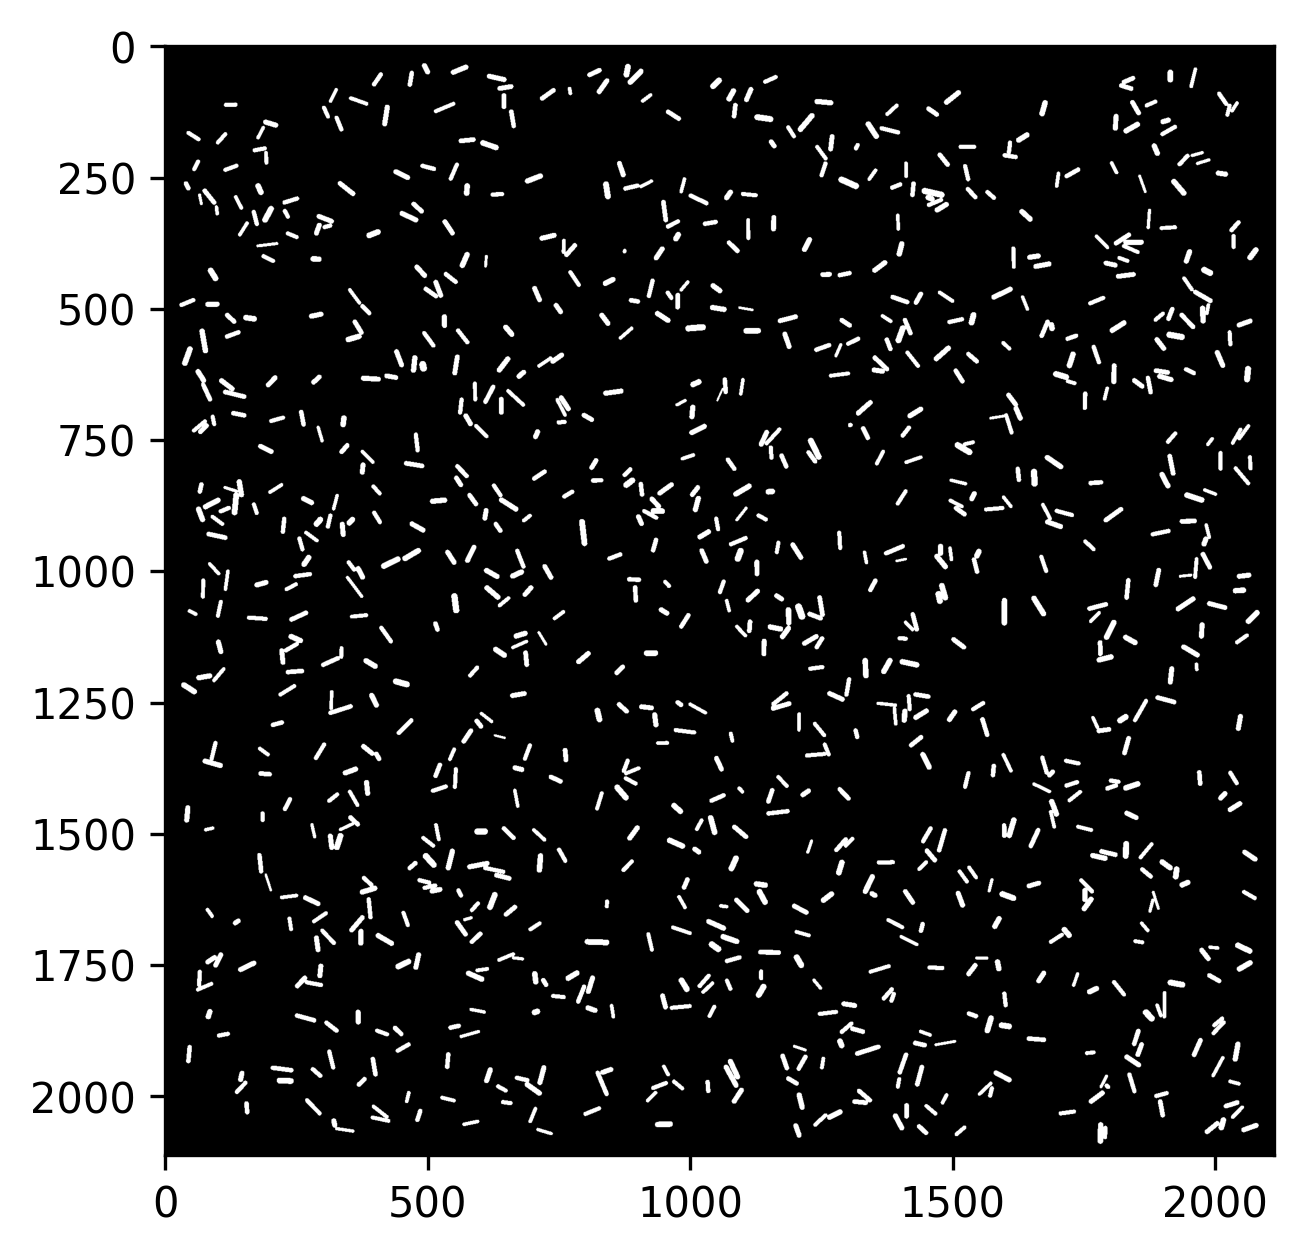

In [13]:
#%% random alignment or initial seeding of cells

data, Ncell = add_round_rects_labels(I, L, data, 1000, Ncell, log=False)
plt.imshow(I)


Drew 674 new cells in 4.270874977111816 s.
Drew 557 new cells in 6.771116018295288 s.
Drew 427 new cells in 10.14750075340271 s.
Drew 413 new cells in 7.873179197311401 s.
Drew 325 new cells in 10.836149454116821 s.


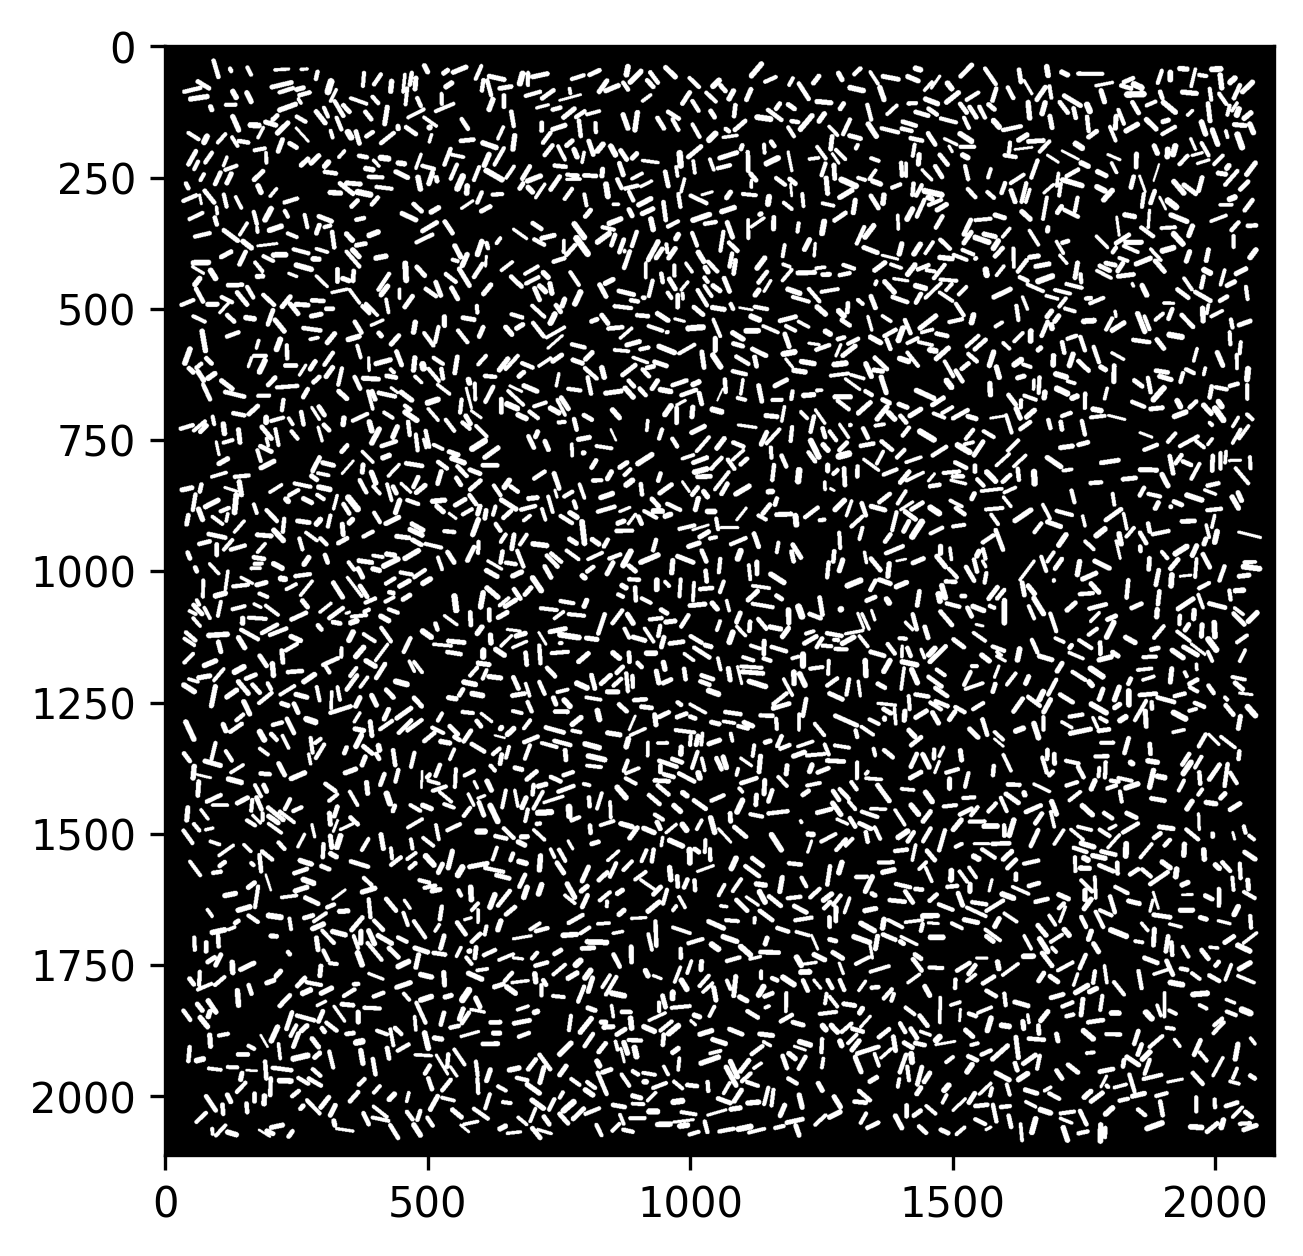

In [14]:
#add cells oriented parallel to nearest cell plus noise term
#while loop is used to draw cells in several steps. This is especially useful for creating "organic" looking clusters
count = 0
while count<5:
    data, Ncell = add_round_rects_labels_aligned(Img = I, Lbl = L, data=data, N=1000, N0 = Ncell, clustered = 0, clust_size=30, noise = 0.05)
    count += 1
plt.imshow(I)

In [ ]:
# add circles (separate data file due to fewer degrees of freedom)
count=0
while count<5:
    data2, Ncell2 = add_circs_labels(I, Lcirc, data2, 1000, Ncell2, clustered = 1, clust_size = 50, thresh=15)
    count += 1
plt.imshow(I)

In [ ]:
#crop and save images to desired folder

#specify output folder
out_path = 'C:/Users/...'

#set widths of edges to be removed
margin = 2*round(l_mean)

#remove image edges
Icrop = I[margin:2048+margin,margin:2048+margin]
Lcrop = L[margin:2048+margin,margin:2048+margin]
Lcirc_crop = Lcirc[margin:2048+margin,margin:2048+margin]

#file names contain some information about rod dimensions, in um.
from PIL import Image
im = Image.fromarray(Icrop)
im.save(os.path.join(out_path,f"{int((l_mean)*20*pix)}x{int(w_mean*20*pix)}_mixed{Ncell}.tif"))
im2 = Image.fromarray(Lcrop)
im2.save(os.path.join(out_path,f"{int((l_mean)*20*pix)}x{int(w_mean*20*pix)}_mixed{Ncell}_masks.tif"))
im3 = Image.fromarray(Lcirc_crop)
im3.save(os.path.join(out_path,f"{int((l_mean)*20*pix)}x{int(w_mean*20*pix)}_mixed{Ncell}_masks_circ.tif"))